In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob  # For file pattern matching
import torch # For PyTorch library
import random
from torchvision.ops import nms
import cv2 # For OpenCV, a computer vision library
import PIL.Image as Image
import matplotlib.pyplot as plt
# Clear GPU cache
torch.cuda.empty_cache()

image_size=256 # Define image size for resizing
batch_size=4
# Determine device to use (GPU if available, otherwise CPU)
device='cuda' if torch.cuda.is_available() else 'cpu'
# Set number of epochs for training
epochs=40
lr=0.0002

# Define directory path for data
dir_path = 'data'
# Define path to the CSV file containing bounding boxes information
csv_file = 'data/train_solution_bounding_boxes (1).csv'

In [17]:
# Read the CSV file containing bounding boxes information into a DataFrame
df = pd.read_csv(csv_file)
df['label']=[1]*len(df)

print(f"Dataframe containing {len(df)} total targets for {len(df.image.unique())} Images \n")
# Display the DataFrame
df

Dataframe containing 559 total targets for 355 Images 



,image,xmin,ymin,xmax,ymax,label
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,1
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,1
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,1
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575,1
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422,1
...,...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284,1
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895,1
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652,1
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864,1


In [18]:
from sklearn.model_selection import train_test_split
train_img_ids, val_img_ids = train_test_split(df.image.unique(),test_size=0.1,random_state=32)
# Split the unique image IDs into training and validation sets

train_df = df[df.image.isin(train_img_ids)]
# Create the training DataFrame by selecting rows where the image ID is in the training set

val_df = df[df.image.isin(val_img_ids)]
# Create the validation DataFrame by selecting rows where the image ID is in the validation set

In [19]:
import torch
import albumentations as A


# Define data augmentation for training set
train_augs=A.Compose([
    A.Resize(image_size,image_size),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=False)

# Define data augmentation for validation set
val_augs=A.Compose([
    A.Resize(image_size,image_size),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=False)

# Define data augmentation for test set (only resizing)
test_augs=A.Compose([
    A.Resize(image_size,image_size)
],is_check_shapes=False)


# Define a custom PyTorch Dataset for car detection
class CarDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, image_ids, df, augs=None, train=True):
        self.df=df
        self.augs=augs
        self.image_ids=image_ids
        if train:
            self.dir_path='data/training_images'
        else:
            self.dir_path='data/testing_images'
            
    def __len__(self):  # Return the total number of images
        return len(self.image_ids)
    
    def __getitem__(self,idx):
        # Get the image ID at the given index
        image_id=self.image_ids[idx]
        image_path=os.path.join(self.dir_path,image_id)
        image=cv2.imread(image_path) # Read the image using OpenCV
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # Convert the image from BGR to RGB

        # Get bounding boxes and labels for the current image
        bboxes = self.df[self.df.image==image_id][['xmin','ymin','xmax','ymax']].values
        labels = self.df[self.df.image==image_id][['label']].values
        
        if self.augs!=None:
            data=self.augs(image=image, bboxes=bboxes, class_labels=['None']*len(bboxes))
            image=data['image']
            bboxes=data['bboxes']

        image = torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        # Convert bounding boxes and labels to PyTorch tensors
        bboxes = torch.Tensor(bboxes).long()
        labels = torch.Tensor(labels).long().squeeze(1)

         # Create a dictionary to store target information
        target={}
        target['boxes']=bboxes
        target['labels']=labels
        
        return image, target
    
    def collate_fn(self,batch):
        return tuple(zip(*batch))

    
# Create instances of the custom dataset for training and validation sets
trainset=CarDetectionDataset(train_img_ids, train_df, augs=train_augs)
valset=CarDetectionDataset(val_img_ids, val_df,augs=val_augs)

# Print the number of training images and total bounding boxes
print(f"{len(trainset)} Training Images containing {len(train_df)} bboxes \n")

319 Training Images containing 491 bboxes 



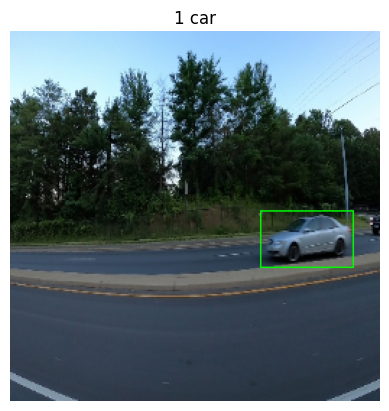

In [22]:
idx=random.randint(0,len(trainset)-1)
# Select a random index from the training dataset

image, target = trainset[idx]
bbox, label = target['boxes'], target['labels']

# Permute the image dimensions from (C, H, W) to (H, W, C) and convert it to a NumPy array
image = image.permute(1,2,0).numpy()

for i in range(len(bbox)):
     # Get the starting point of the bounding box
    sp=(int((bbox[i][0]).item()),int((bbox[i][1]).item()))
     # Get the ending point of the bounding box
    ep=(int((bbox[i][2]).item()),int((bbox[i][3]).item()))
    # Define the color for the bounding box (green)
    c = (0,255,0)
    image = cv2.rectangle(image, sp, ep, c, 1) 

plt.imshow(image) # Display the image with bounding boxes using Matplotlib
plt.axis('off') # Hide the axis
plt.title(str(len(bbox))+' car')  # Set the title to display the number of bounding boxes (cars)
plt.show() # Show the image

In [23]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, collate_fn=trainset.collate_fn ,shuffle=True)

# Create DataLoader for validation data without shuffling
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, collate_fn=valset.collate_fn)

# Print the number of training batches
print(f"Number of Batches: {len(trainloader)}")

Number of Batches: 80


#### Model - Faster RCNN

In [24]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(preTrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Get the number of input features for the classifier head

model.roi_heads.box_predictor = FastRCNNPredictor(in_features,2) 
model.to(device); # Move the model to the specified device (GPU if available, otherwise CPU)

#### Model - SSD

In [25]:
import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model_ssd = torchvision.models.detection.ssd300_vgg16(preTrained=True, num_classes=2)

# Load a pre-trained SSD model with a VGG16 backbone

# Move the model to the specified device (GPU if available, otherwise CPU)
model_ssd.to(device);

In [26]:
from tqdm.auto import tqdm


# Define the training function
def trainarc(model, dataloader, opt):
    model.train() # Set the model to training mode
    train_loss=0.0
    # Initialize the training loss
    
    
    for image, target in tqdm(dataloader):
        image = list(i.to(device) for i in image)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]
        
        opt.zero_grad() # Zero the gradients
        losses = model(image, target)
        loss = sum(loss for loss in losses.values()) # Sum up the losses
        loss.backward()
        opt.step()  # Update the model parameters
        
        train_loss+=loss.item()  # Accumulate the training loss
        
    return train_loss/len(dataloader)

In [10]:
best_train_loss=np.Inf 

opt = torch.optim.Adam(model_ssd.parameters(), lr=lr)

for i in range(epochs):
    train_loss = trainarc(model_ssd, trainloader, opt)
                  
    print(f"Epoch: {i+1}:- TrainLoss: {train_loss}")
    # Print the epoch number and training loss
    
    if train_loss<best_train_loss:
        torch.save(model_ssd.state_dict(),'model_ssd.pt')
        print("Model Updated")
        best_train_loss=train_loss
        
print(f"DONE.\nTrainLoss: {best_train_loss}")

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1:- TrainLoss: 6.402982866764068
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 2:- TrainLoss: 4.675389301776886
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 3:- TrainLoss: 4.193698140978813
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 4:- TrainLoss: 4.033857536315918
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 5:- TrainLoss: 3.885940983891487
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 6:- TrainLoss: 3.7699764519929886
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 7:- TrainLoss: 3.6216701209545135
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 8:- TrainLoss: 3.598712667822838
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 9:- TrainLoss: 3.5583529263734817
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 10:- TrainLoss: 3.478778412938118
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 11:- TrainLoss: 3.417679926753044
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 12:- TrainLoss: 3.413704162836075
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 13:- TrainLoss: 3.390567260980606
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 14:- TrainLoss: 3.3287962675094604
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 15:- TrainLoss: 3.321247896552086
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 16:- TrainLoss: 3.24876883327961
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 17:- TrainLoss: 3.2290268048644064
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 18:- TrainLoss: 3.163318473100662
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 19:- TrainLoss: 3.1707429349422456


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 20:- TrainLoss: 3.1898437082767486


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 21:- TrainLoss: 3.0917030394077303
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 22:- TrainLoss: 3.10306915640831


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 23:- TrainLoss: 3.0954242989420893


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 24:- TrainLoss: 3.0847663924098017
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 25:- TrainLoss: 2.9853181287646295
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 26:- TrainLoss: 2.9857528492808343


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 27:- TrainLoss: 3.065947648882866


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 28:- TrainLoss: 3.073983962833881


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 29:- TrainLoss: 3.0364447981119156


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 30:- TrainLoss: 2.982564868032932
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 31:- TrainLoss: 2.965699943900108
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 32:- TrainLoss: 2.970292256772518


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 33:- TrainLoss: 2.869140715897083
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 34:- TrainLoss: 2.913631704449654


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 35:- TrainLoss: 2.9232969284057617


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 36:- TrainLoss: 2.88495791554451


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 37:- TrainLoss: 2.9878520026803015


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 38:- TrainLoss: 2.9207279592752458


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 39:- TrainLoss: 2.8749409198760985


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 40:- TrainLoss: 2.867794981598854
Model Updated
DONE.
TrainLoss: 2.867794981598854


#### Model Inference

## model_ssd.load_state_dict(torch.load('model_ssd.pt'))
idx=random.randint(1,len(valset)-1)
image, target = valset[]
image = image.permute(1,2,0).numpy()
image = test_augs(image=image)['image']

plt.imshow(image)

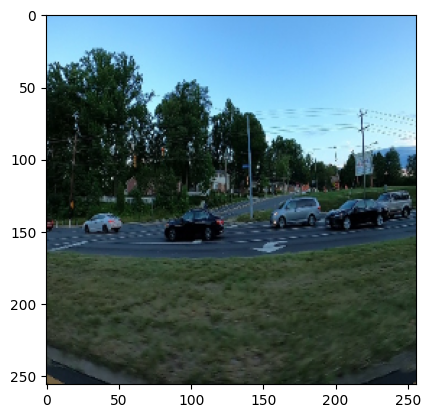

In [27]:
model_ssd.load_state_dict(torch.load('model_ssd.pt'))
idx=random.randint(1,len(valset)-1)
image, target = valset[28]

# Permute the image dimensions from (C, H, W) to (H, W, C) and convert it to a NumPy array
image = image.permute(1,2,0).numpy()
image = test_augs(image=image)['image']

plt.imshow(image) # Display the image using Matplotlib

In [28]:

# Convert the image to a PyTorch tensor and transpose its dimensions from (H, W, C) to (C, H, W)
img = torch.Tensor(np.transpose(image,(2,0,1))) 

model_ssd.eval() # Set the SSD model to evaluation mode
pred = model_ssd([img.to(device)])
pred # Display the prediction results

[{'boxes': tensor([[ 21.6977, 132.2266,  54.4487, 154.3690],
          [ 77.4899, 133.4424, 126.1804, 158.5689],
          [151.5088, 120.3552, 189.3473, 149.2701],
          [192.2342, 124.8766, 235.2847, 151.9276],
          [217.7020, 118.0856, 254.2510, 144.1692],
          [189.8241, 181.8889, 233.4932, 214.7539],
          [203.4774, 127.2755, 247.1466, 160.1405],
          [ 66.9441,  86.3155, 110.6133, 119.1805],
          [189.8241, 222.8489, 233.4932, 255.7139],
          [ 94.2507,  99.9688, 137.9199, 132.8339],
          [176.1708, 127.2755, 219.8399, 160.1405],
          [107.9041, 140.9288, 151.5732, 173.7939],
          [176.1708,  31.7022, 219.8399,  64.5672],
          [121.5574, 168.2355, 165.2266, 201.1005],
          [162.5174, 222.8489, 206.1866, 255.7139],
          [135.2108, 127.2755, 178.8799, 160.1405],
          [ 80.5974,  72.6622, 124.2666, 105.5272],
          [  0.0000,  18.0488,  42.3466,  50.9139],
          [ 66.9441,  31.7022, 110.6133,  64.5672],
   

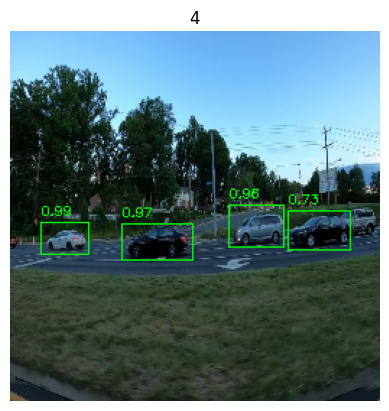

In [29]:

# Permute the image dimensions from (C, H, W) to (H, W, C) and convert it to a NumPy arrayimage = img.permute(1,2,0).detach().cpu().numpy().copy()
bbox = pred[0]['boxes'].detach().cpu().numpy()
score = pred[0]['scores'].detach().cpu().numpy()

score_threshold = np.where(pred[0]['scores'].detach().cpu().numpy()>0.4)[0]
ixs = nms(torch.Tensor(bbox),torch.Tensor(score),0.05)
filt = np.intersect1d(ixs, score_threshold)

# Apply filtering to bounding boxes and scores
bbox = bbox[filt]
score = score[filt]

for i in range(len(bbox)):
    sp=(int((bbox[i][0]).item()),int((bbox[i][1]).item()))
    ep=(int((bbox[i][2]).item()),int((bbox[i][3]).item()))
    cv2.rectangle(image, sp, ep, (0,255,0), 1) 
    cv2.putText(image, str(score[i])[:4], (sp[0], sp[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,0), 1)

# Display the image with bounding boxes and scores using Matplotlib
plt.imshow(image)
plt.axis('off')
plt.title(str(len(filt)))
plt.show()